<a href="https://colab.research.google.com/github/YYW-UMN/RNA-seq-InfluenzaNP-CD8-T-cells/blob/main/MIS11602_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

In [2]:
## Install packages
system('apt-get -q install libgsl-dev', intern = TRUE)
system('apt-get install libcairo2-dev', intern = TRUE) # for Cairo package that is required by ComplexHeatmap package
install.packages('BiocManager')

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "The following additional packages will be installed:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "  libgsl23 libgslcblas0"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
 [6] "Suggested packages:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [7] "  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html"                                                           

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "The following additional packages will be installed:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
 [6] "Suggested packages:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [7] "  libcairo2-doc"                                                                                                       

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




## Install packages

In [14]:
required_packages <- c(
  'DESeq2', 'dplyr', 'tximportData','tximport',
  'org.Mm.eg.db', 'org.Hs.eg.db',
  'ComplexHeatmap', 'ggnewscale', # plotting
  'goseq',
  'biomaRt',
  'DOSE', 'enrichplot', # pathway analysis
  'VennDiagram',
  'limma',
  'ggwordcloud',
  'eulerr',
  'ggplot2',
  'ggrepel',
  'googledrive',
  'tibble',
  'circlize',
  'patchwork',
  'stringi',
  'stringr',
  'clusterProfiler',
  'formattable',
  'reshape2',
  "tidyr"
)
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    install.packages(missing_packages)
}
# Load packages
invisible(lapply(required_packages, library, character.only = TRUE))

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Installing package(s) 'tximport'

Old packages: 'broom', 'cpp11', 'gert', 'glue', 'openssl', 'readr',
  'sessioninfo', 'tibble', 'tinytex', 'uuid', 'vroom', 'xfun', 'nlme'



## Upload files

In [17]:
## Load data
system("gdown --id 1PRhbY53Uxw-EvnYVhGPDM4dnALZjRLJr")
system('ls .', intern = TRUE)
abundance_files <- c(
  'MIS11602A1_mouse_NP__CD8___1_trimmed.tsv',
  'MIS11602A2_mouse_NP__CD8___2_trimmed.tsv',
  'MIS11602A3_mouse_NP__CD8___3_trimmed.tsv',
  'MIS11602A4_mouse_NP__CD8___4_trimmed.tsv'
)
abundance_files %>% file.exists() # double check

[1] "GO_terms_final_10_27.csv"                
 [2] "heatmap_long_gene_names.png"             
 [3] "heatmap_short_gene_names.png"            
 [4] "manually_checked_2.csv"                  
 [5] "manually_checked.csv"                    
 [6] "MIS11602A1_mouse_NP__CD8___1_trimmed.tsv"
 [7] "MIS11602A2_mouse_NP__CD8___2_trimmed.tsv"
 [8] "MIS11602A3_mouse_NP__CD8___3_trimmed.tsv"
 [9] "MIS11602A4_mouse_NP__CD8___4_trimmed.tsv"
[10] "MIS11602.ipynb"                          
[11] "NPCD8T_cells-Figures-2021_11_15.pptx"    
[12] "sample_data"                             
[13] "volcano.png"                             
[14] "Weiping_hl_genes.csv"

[1] TRUE TRUE TRUE TRUE

## Parameters


In [18]:
MIN_READS = 5
MIN_SAMPLES = 2
species = "mmusculus_gene_ensembl"
PVAL <- 0.05
PVAL_TOP_10 <- 0.01
FC_DOWN <- -1         # Notes: log2(1/2) = -1; log2(1/4) = -2 
FC_UP <- 1            # Notes: log2(2) = 1; log2(4) = 2 
TOP_N <- 10

## Functions

In [19]:
########### FUNCTION: format raw data and annotate
format_and_annotate <- function(abundance_files, MIN_READS, MIN_SAMPLES, species){
  # step 1
  sprintf("1. Read the RNA-seq counts as SummarizedExperiment format") %>% message()
  x <- lapply(abundance_files, function(f) read.table(f, sep = '\t', header = TRUE))
  counts <- do.call('cbind', lapply(x, function(xx) xx$est_counts)) %>%
      as.matrix() %>%
      round()
  rownames(counts) <- x[[1]]$target_id
  se <- SummarizedExperiment(
    assays = list(counts = counts), 
    rowData = data.frame(target_id = rownames(counts)),
    colData= data.frame(
      abundance_file = abundance_files, 
      dose = c('low', 'low', 'high', 'high')))
  rowData(se)$ensembl_transcript_id  <- gsub('\\.\\d+', '', rowData(se)$target_id)
  colData(se)$sample_id <- sprintf('%s_%d', colData(se)$dose, rep(1:2, 2))
  
  # step 2
  sprintf("2. Filter number of transcripts that have at least X reads in at least Y samples:") %>% message()
  keep <- rowSums(assays(se)$counts > MIN_READS) >= MIN_SAMPLES
  sprintf('   Number of transcripts that have at least %d reads in at least %d samples: %d/%d', MIN_READS, MIN_SAMPLES, sum(keep), nrow(se)) %>% message()
  se <- se[keep]
  
  # step 3
  sprintf("3. Retrieve the gene symbols") %>% message()
  mouse <-  useEnsembl(biomart="ensembl", dataset = species) # takes a couple of minutes

  # step 4
  sprintf("4. Map EnsEMBL transcript IDs to ensembl gene id, gene symbol, entrezgene id") %>% message()
  bm <- getBM(
    attributes = c('ensembl_transcript_id','ensembl_gene_id','external_gene_name', 'entrezgene_accession', 'entrezgene_trans_name','entrezgene_id'),
    filters = "ensembl_transcript_id", 
    values = rowData(se)$ensembl_transcript_id,
    mart = mouse)

  df <- data.frame(
    id = 1:nrow(se), 
    ensembl_transcript_id = rowData(se)$ensembl_transcript_id) %>%
    left_join(bm, by = 'ensembl_transcript_id')  
  rowData(se)$ensembl_gene_id <- rep(NA, nrow(se))
  rowData(se)$ensembl_gene_id[df$id] <- df$ensembl_gene_id
  rowData(se)$symbol <- rep(NA, nrow(se))
  rowData(se)$symbol[df$id] <- df$external_gene_name
  rowData(se)$entrezgene_id <- rep(NA, nrow(se))
  rowData(se)$entrezgene_id[df$id] <- df$entrezgene_id
  return(se)
}

########### FUNCTION: run DeSeq2
run_deseq2 <- function(se){
  se <- DESeqDataSet(se, design = ~ dose)
  se <- estimateSizeFactors(se)
  se <- DESeq(se)
  # assays(se)$normalized_counts <- log2(counts(se, normalized = TRUE) + 1) 
  res <- results(se, contrast = c('dose', 'high', 'low'))
  summary(res) %>% message()
  return(res)
}

########### FUNCTION: clean up results
clean_up_res <- function(se, res, PVAL, FC_UP, FC_DOWN){
  # label the DEGs
  res2 <- res %>%
  as.data.frame() %>% 
  mutate(
    ensembl_gene_id = rowData(se)$ensembl_gene_id,
    ensembl_transcript_id = rowData(se)$ensembl_transcript_id,
    symbol = rowData(se)$symbol,
    entrezgene_id = rowData(se)$entrezgene_id
  ) %>%
  mutate(is_down = !is.na(padj) & padj < PVAL & log2FoldChange < FC_DOWN) %>%
  mutate(is_up = !is.na(padj) & padj < PVAL & log2FoldChange > FC_UP) %>%
  mutate(labels = if_else(is_down == TRUE, "Down",if_else(is_up == TRUE, "Up","No"))) %>%
  mutate(is_sig = !is.na(padj) & padj < PVAL & abs(log2FoldChange) > FC_UP) # if all three met,then is_sig = TRUE
  cat(" labels added to DESeq2 results") %>% message()

  if ((length(unique(rownames(res2)))!= nrow(res2)) && (nrow(assays(se)$counts) != length(unique(rownames(res2))))){
    cat("res2 and se can't be merged, please check") %>% message()
  } else {
  
  # add count data
  res3 <- merge(res2,assays(se)$counts,by='row.names',all=TRUE) 
  res3 <-column_to_rownames(as.data.frame(res3), var = "Row.names") %>%
    rename(Low_dose_rep_1 = V1,Low_dose_rep_2 = V2, High_dose_rep_1 = V3, High_dose_rep_2 = V4) %>% 
    filter(!is.na(padj)) %>%
    mutate(labels_2 = if_else(
    (is_sig == TRUE & Low_dose_rep_1 == 0 & Low_dose_rep_2 == 0),"Induced",
      if_else(
        (is_sig == TRUE & High_dose_rep_1 == 0 & High_dose_rep_2 == 0), "Inhibited","No")), .after = labels) %>%
    mutate(padj_rounded = round(padj, 3), .after = 'padj') %>%
    dplyr::select(
       baseMean, log2FoldChange, lfcSE, stat, padj, padj_rounded, ensembl_gene_id, ensembl_transcript_id, symbol, entrezgene_id, labels, labels_2,
       Low_dose_rep_1, Low_dose_rep_2, High_dose_rep_1, High_dose_rep_1, High_dose_rep_2) %>%
    arrange(desc(log2FoldChange)) 
    cat(" counts added to DESeq2 results") %>% message()
  return(res3)
  }
}

########### FUNCTION: summarize
summary_table <- function(res_genes){
  total_genes_mapped <- res_genes %>% distinct_at(vars(symbol)) %>% nrow()
  total_deg <- res_genes %>% filter(labels != "No") %>% filter(padj <= 0.05) %>% distinct_at(vars(symbol)) %>% nrow()
  up_deg <- res_genes %>% filter(labels == "Up") %>% filter(padj <= 0.05) %>% distinct_at(vars(symbol)) %>% nrow()
  down_deg <- res_genes %>% filter(labels == "Down") %>% filter(padj <= 0.05) %>% distinct_at(vars(symbol)) %>% nrow()
  induced_deg <- res_genes %>% filter(labels_2 == "Induced") %>% filter(padj <= 0.05) %>% distinct_at(vars(symbol)) %>% nrow()
  suppressed_deg <- res_genes %>% filter(labels_2 == "Inhibited") %>% filter(padj <= 0.05) %>% distinct_at(vars(symbol)) %>% nrow()
  overall <- matrix(c(
    total_genes_mapped, total_deg, up_deg, down_deg,induced_deg, suppressed_deg,
    100, 
    round(total_deg/total_genes_mapped*100,2), 
    round(up_deg/total_genes_mapped*100,2), 
    round(down_deg/total_genes_mapped*100,2), 
    round(induced_deg/total_genes_mapped*100,2), 
    round(suppressed_deg/total_genes_mapped*100,2)),
    nrow = 2, ncol = 6, byrow = TRUE)
  rownames(overall) <- c('Count','Percentage(%)')
  colnames(overall) <- c('Total_genes','Signficant_genes','Up','Down','Induced','Suppressed')
  return(overall)
}

########### FUNCTION: get top N genes/trans & up/down
get_tops <- function(res_table, PVAL_TOP_10, TOP_N, up_regulated = TRUE, transcript = TRUE, sort_by_fc = TRUE){
  if (sort_by_fc == TRUE) {
    if (up_regulated == TRUE) {        
      topN_up <- res_table %>% 
      filter(labels == "Up" & padj <= PVAL_TOP_10) %>%
      arrange(desc(log2FoldChange)) %>%
      mutate(rank_up = 1:length(log2FoldChange), .after = labels_2) %>%
      distinct()
      up <- topN_up[1:TOP_N,c('id', 'labels','labels_2','symbol')]  # keep only top N
      if (transcript == TRUE){         # sort by fc + up + transcripts 
        write.csv(topN_up[1:10,],paste0("Top",TOP_N,"_up_trans_",Sys.Date(),".csv"), row.names = FALSE)
      } else {                         # sort by fc + up + genes
        write.csv(topN_up[1:10,],paste0("Top",TOP_N,"_up_genes_",Sys.Date(),".csv"), row.names = FALSE)}
      return(up)
    } else {
      topN_down <- res_table %>%       
      filter(labels == "Down" & padj <= PVAL_TOP_10) %>%
      arrange((log2FoldChange)) %>%
      mutate(rank_down = 1:length(log2FoldChange)) %>%
      distinct()
      down <- topN_down[1:TOP_N,c('id', 'labels','labels_2','symbol')]  # keep only top N
      if (transcript == TRUE){         # sort by fc + down + transcripts 
        write.csv(topN_down[1:10,],paste0("Top",TOP_N,"_down_trans_",Sys.Date(),".csv"), row.names = FALSE)
      } else {                         # sort by fc + down + genes 
        write.csv(topN_down[1:10,],paste0("Top",TOP_N,"_down_genes_",Sys.Date(),".csv"), row.names = FALSE)}
      return(down)
   }
  } else {
    if (up_regulated == TRUE) {        
      topN_up <- res_table %>% 
      filter(labels == "Up" & padj <= PVAL_TOP_10) %>%
      arrange(padj) %>%
      mutate(rank_up = 1:length(padj), .after = labels_2) %>%
      distinct()
      up <- topN_up[1:TOP_N,c('id', 'labels','labels_2','symbol')]  # keep only top N
      if (transcript == TRUE){
        write.csv(topN_up[1:10,],paste0("Top",TOP_N,"_up_trans_",Sys.Date(),".csv"), row.names = FALSE)
      } else {
        write.csv(topN_up[1:10,],paste0("Top",TOP_N,"_up_genes_",Sys.Date(),".csv"), row.names = FALSE)}
      return(up)
    } else {
      topN_down <- res_table %>% 
      filter(labels == "Down" & padj <= PVAL_TOP_10) %>%
      arrange(padj) %>%
      mutate(rank_down = 1:length(padj)) %>%
      distinct()
      down <- topN_down[1:TOP_N,c('id', 'labels','labels_2','symbol')]  # keep only top N
      if (transcript == TRUE){
        write.csv(topN_down[1:10,],paste0("Top",TOP_N,"_down_trans_",Sys.Date(),".csv"), row.names = FALSE)
      } else {
        write.csv(topN_down[1:10,],paste0("Top",TOP_N,"_down_genes_",Sys.Date(),".csv"), row.names = FALSE)}
      return(down)
    }
  }
}



## Format as SummerizeExperiment, filtering and add annotation

In [20]:
se <- format_and_annotate(abundance_files, MIN_READS, MIN_SAMPLES, species)

1. Read the RNA-seq counts as SummarizedExperiment format

2. Filter number of transcripts that have at least X reads in at least Y samples:

   Number of transcripts that have at least 5 reads in at least 2 samples: 79054/118489

3. Retrieve the gene symbols

Ensembl site unresponsive, trying useast mirror

Ensembl site unresponsive, trying useast mirror

4. Map EnsEMBL transcript IDs to ensembl gene id, gene symbol, entrezgene id



# Run DESeq2 analysis

In [58]:
files <- abundance_files
se <- tximport(abundance_files, type = "kallisto", tx2gene = tx2gene, ignoreAfterBar = TRUE)
res <- run_deseq2(se)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = ~dose):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 79054 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2503, 3.2%
LFC < 0 (down)     : 1344, 1.7%
outliers [1]       : 0, 0%
low counts [2]     : 7664, 9.7%
(mean count < 9)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



# Map Annotations 

## Use getBM() to get annotations


In [22]:
mouse <-  useEnsembl(biomart="ensembl", dataset = species) # takes a couple of minutes
bm <- getBM(
    attributes = c('ensembl_transcript_id_version','ensembl_transcript_id','ensembl_gene_id','external_gene_name', 'entrezgene_accession', 'entrezgene_trans_name','entrezgene_id'),
    filters = "ensembl_transcript_id", 
    values = rowData(se)$ensembl_transcript_id,
    mart = mouse)
bm <- bm %>% rename(symbol = external_gene_name) %>% select(symbol, entrezgene_id, ensembl_gene_id)

Ensembl site unresponsive, trying asia mirror



## Manually add unmapped gene symbols




In [23]:
res_trans <- clean_up_res(se, res, PVAL, FC_UP, FC_DOWN)
check <- which((!is.na(res_trans$ensembl_transcript_id) & is.na(res_trans$symbol) & res_trans$labels != "No")) # subset the unmapped to csv file
# write.csv(res_trans[check,], file = "manually_check_2.csv") if first time
# res_trans
res_trans <- clean_up_res(se, res, PVAL, FC_UP, FC_DOWN)
check <- which((!is.na(res_trans$ensembl_transcript_id) & is.na(res_trans$symbol) & res_trans$labels != "No")) # subset the unmapped to csv file
res_trans <- res_trans[-check,]                              # check rows removed
checked <- read.csv("manually_checked_2.csv", header = TRUE) # read the new annotations
colnames(checked)[1] <- c('id')
checked2 <- merge(checked, bm, by = 'symbol') %>%
  select(-entrezgene_id.x) %>%
  select(-ensembl_gene_id.x) %>%
  rename(entrezgene_id = entrezgene_id.y) %>%
  rename(ensembl_gene_id = ensembl_gene_id.y) %>%
  distinct()      
                                           
res_trans <- res_trans %>% 
  rownames_to_column(var = "id") %>% 
  rbind(checked2) %>%
  filter(!is.na(symbol))                                   

res_genes <- res_trans %>%
  group_by(symbol) %>%  
  summarize(padj=min(padj)) %>% 
  arrange(padj) %>%
  left_join(res_trans, by = c('symbol','padj')) %>% 
  distinct()

 labels added to DESeq2 results

 counts added to DESeq2 results

 labels added to DESeq2 results

 counts added to DESeq2 results

# Results: 

### Count summary of DEGs

In [24]:
summary_table(res_genes)

,Total_genes,Signficant_genes,Up,Down,Induced,Suppressed
Count,23686,1571.00,890.00,681.00,144.00,179.00
Percentage(%),100,6.63,3.76,2.88,0.61,0.76


### Volcano: 




In [25]:
wp <- read.csv('Weiping_hl_genes.csv', header = TRUE)
# Top genes
# Rank by FC
up_genes_sort_by_fc   <- get_tops(res_genes, PVAL_TOP_10, TOP_N, up_regulated = TRUE, transcript = FALSE, sort_by_fc = TRUE)
down_genes_sort_by_fc <- get_tops(res_genes, PVAL_TOP_10, TOP_N, up_regulated = FALSE, transcript = FALSE, sort_by_fc = TRUE)
# Rank by adjusted p-value
up_genes_sort_by_p  <- get_tops(res_genes, PVAL_TOP_10, TOP_N, up_regulated = TRUE, transcript = FALSE, sort_by_fc = FALSE)
down_genes_sort_by_p <- get_tops(res_genes, PVAL_TOP_10, TOP_N, up_regulated = FALSE, transcript = FALSE, sort_by_fc = FALSE)

alltop_ups <- rbind(up_genes_sort_by_fc, up_genes_sort_by_p) %>% distinct()
alltop_ds <- rbind(down_genes_sort_by_fc, down_genes_sort_by_p) %>% distinct()
tops <- rbind(alltop_ups, alltop_ds) %>% rename(label_tops = symbol) 

# All genes
res_genes_outlier_removed <- res_genes %>% filter(symbol != "Gm15056") %>% filter(symbol != "Cadm1") # not related to CD8+
res = res_genes_outlier_removed # note that res is the final results data 
res <- res %>% mutate(label_tops = symbol)
res2 <- res %>% select(id, labels, labels_2, label_tops) 
hilight <- wp %>% left_join(res2, by = "label_tops") # just to fill info for the highlighted genes
keep <- intersect(hilight$label_tops,tops$label_tops) # these are the top genes related to CD8+ functions
hilight <- hilight %>% filter(label_tops %in% keep) # find the genes overlapping the highlight list and the top list
res <- res %>% mutate(gene_label = if_else(label_tops %in% hilight$label_tops, symbol, ""))
res <- res %>% mutate(wp_label = if_else(label_tops %in% wp$label_tops, symbol, ""))
res <- res %>% mutate(on_wp_list = if_else(label_tops %in% wp$label_tops, 1, 0))
res <- res %>% select(
  symbol, on_wp_list, wp_label, gene_label, padj, log2FoldChange, labels, labels_2, Low_dose_rep_1,Low_dose_rep_2, High_dose_rep_1, High_dose_rep_2)
res <- res %>% rename(color_label = labels) 
res <- res %>% rename(top_label = labels_2)
res$color_label <- as.factor(res$color_label)
levels(res$color_label) <- c("Down","No","Up")


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


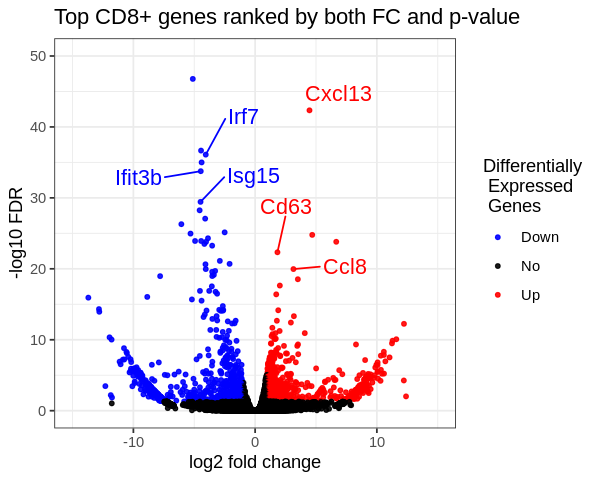

In [26]:
options(repr.plot.width = 5, repr.plot.height = 4)
main_title = paste0("Top CD8+ genes ranked by both FC and p-value")
g = ggplot(data=res, 
            aes(x=log2FoldChange, y=-log10(padj), 
                # Colour based on the threshold defined before
                colour=color_label)) +
    # Define the look of the points
    geom_point(alpha=0.9, size=1) +
    # Hide the legend
    theme(legend.position=c(10, 60), legend.justification = c(10, 60)) +
    # Apply another theme
    theme_bw() + 
    xlab("log2 fold change") + 
    ylab("-log10 FDR") + 
    labs(color='Differentially\n Expressed\n Genes') +
    xlim(-15,15) + 
    ylim(0, 50) + # change the y lim here 
    guides(size = FALSE) +
    ggtitle(main_title) +
    geom_text_repel(aes(label=gene_label, size = 13), box.padding = 2, max.overlaps = Inf, show.legend = FALSE) + # labels are here!
    scale_color_manual(values=c("blue", "black", "red"))
g

### Barplot of GO terms:

In [27]:
##### By ensembl_gene_id ##### 
# all genes
glist <- res_genes %>% arrange(desc(log2FoldChange)) %>% pull(log2FoldChange)
names(glist) <- res_genes$ensembl_gene_id
# all sig genes
siglist <- res_genes %>% filter(labels != "No") %>% arrange(desc(log2FoldChange)) %>% pull(log2FoldChange)
names(siglist) <- res_genes %>% filter(labels != "No") %>% pull(ensembl_gene_id)

In [28]:
test_list <- names(siglist)
bkgd_list <- names(glist)
ego <- enrichGO(gene          = test_list,
                universe      = bkgd_list,
                OrgDb         = org.Mm.eg.db,
                ont           = "BP",
                keyType       = 'ENSEMBL',
                pAdjustMethod = "fdr",
                pvalueCutoff  = 0.05,
                readable      = TRUE)

In [29]:
finalgo <- read.csv("GO_terms_final_10_27.csv", header = TRUE)
gobar <- ego %>% filter(ID %in% finalgo$ID)
gobar <- gobar@result %>% as.data.frame() %>% select(ID, Description, p.adjust, Count) %>% arrange(p.adjust)
gobar

,ID,Description,p.adjust,Count
,<chr>,<chr>,<dbl>,<int>
GO:0009615,GO:0009615,response to virus,5.449038e-10,64
GO:0019221,GO:0019221,cytokine-mediated signaling pathway,2.968749e-08,69
GO:0022407,GO:0022407,regulation of cell-cell adhesion,7.868581e-04,64
GO:0007159,GO:0007159,leukocyte cell-cell adhesion,2.291985e-03,53
GO:0001558,GO:0001558,regulation of cell growth,2.936185e-03,59
GO:0072676,GO:0072676,lymphocyte migration,8.489806e-03,20
GO:0007015,GO:0007015,actin filament organization,1.379117e-02,57
GO:0042098,GO:0042098,T cell proliferation,1.707103e-02,33
GO:0002697,GO:0002697,regulation of immune effector process,5.561083e-02,48


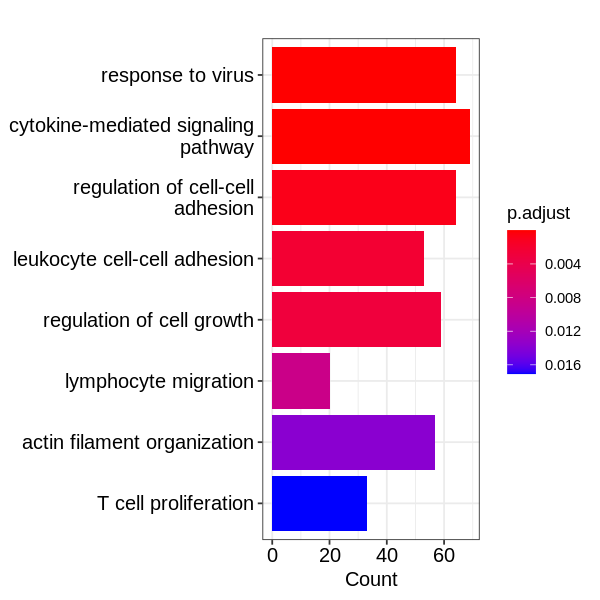

In [30]:
options(repr.plot.width = 5, repr.plot.height = 5)
finalgo <- read.csv("GO_terms_final_10_27.csv", header = TRUE)
gobar <- ego %>% filter(ID %in% finalgo$ID)
barplot(gobar, showCategory = nrow(finalgo))

## Heatmap of key genes:


### Prepare data

In [31]:
gomat <- res %>% filter(on_wp_list == 1)
bm_to_show <- getBM(
    attributes = c('external_gene_name','description'),
    filters = "external_gene_name", 
    values = gomat$symbol,
    mart = mouse) %>% 
    rename(symbol = external_gene_name) %>% 
    mutate(gene_name = gsub("\\[[^\\]]*\\]", "", description, perl=TRUE)) %>%
    select(-c('description'))
label_order <- c("Induced", "Up", "Suppressed","Down")
gomat <- gomat %>% left_join(bm_to_show) %>%
  mutate(gene_description = paste(symbol, gene_name, sep = " - ")) %>%       
  select(-c("gene_name")) %>%
  mutate(label = ifelse(color_label == "Down", 
    ifelse(top_label == "Inhibited","Suppressed","Down"),
      ifelse(color_label == "Up",
        ifelse(top_label == "Induced","Induced","Up"), "No")), .after = padj) %>%  # this is to combine labels
  arrange(sapply(label, function(y) which(y == label_order))) %>%
  select(-c("on_wp_list","wp_label","gene_label","color_label","top_label")) %>%
  relocate(gene_description, .after = symbol)
  gomat <- gomat %>% filter(symbol != "Cadm1") %>% filter(symbol != "Clec9a") # these genes are mostly involved in innate function, hence not show in the heatmap
  head(gomat)

Joining, by = "symbol"



symbol,gene_description,padj,label,log2FoldChange,Low_dose_rep_1,Low_dose_rep_2,High_dose_rep_1,High_dose_rep_2
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cd86,Cd86 - CD86 antigen,6.168515e-05,Induced,10.301713,0,0,487,27
Il15,Il15 - interleukin 15,1.877410e-03,Induced,9.278716,0,0,241,12
Cxcl13,Cxcl13 - chemokine (C-X-C motif) ligand 13,4.563999e-43,Up,4.465008,280,175,5246,5523
Cd63,Cd63 - CD63 antigen,4.674112e-23,Up,1.833192,4580,4424,17817,16808
Ccl8,Ccl8 - chemokine (C-C motif) ligand 8,1.090252e-20,Up,3.148001,409,281,3781,2813
Adam17,Adam17 - a disintegrin and metallopeptidase domain 17,8.896810e-09,Up,2.615260,1077,1597,6891,10768


### Prepare Heatmap

In [32]:
top_annotation = HeatmapAnnotation(dose = anno_block(gp = gpar(fill = 2:3),
        labels = c("low dose", "high dose"), 
        labels_gp = gpar(col = "white", fontsize = 1)))
      
# Data for plots
y <- gomat %>% select("Low_dose_rep_1",	"Low_dose_rep_2","High_dose_rep_1","High_dose_rep_2") %>% as.data.frame()
rownames(y) <- gomat$gene_description

# DOSE labels for plots
column_annotation <- HeatmapAnnotation(
  dose = colData(se)$dose,
  col = list(Dose = c('low' = 'seagreen1','high' = 'seagreen4')),
  show_legend = TRUE,
  annotation_legend_param = list(dose = list(direction = "horizontal", title = "Dose")))

# Value label
col_fun <- colorRamp2(c(-2, 0, 2), c("blue", "black", "red"))

# Heatmap 1: cells and gene names with description 
h_short_gene_names <- Heatmap(
  t(scale(t(y))),
  row_split = factor(gomat$label, levels = c("Induced","Up","Suppressed","Down")),
  cluster_rows = TRUE,
  cluster_columns = FALSE,
  show_column_dend = FALSE,
  show_row_dend = FALSE,
  show_column_names = FALSE,
  col = col_fun,
  width = unit(20, "mm"),
  top_annotation = column_annotation,
  heatmap_legend_param = list(direction = "horizontal", title = "Scaled Expression Value"),
  rect_gp = gpar(col = "white", lwd = 0.5)) # white border 

# Heatmap 1*: cells and gene names NO description
rownames(y) <- gomat$symbol
h_long_gene_names <- Heatmap(
  t(scale(t(y))),
  row_split = factor(gomat$label, levels = c("Induced","Up","Suppressed","Down")),
  cluster_rows = TRUE,
  cluster_columns = FALSE,
  show_column_dend = FALSE,
  show_row_dend = FALSE,
  show_column_names = FALSE,
  col = col_fun,
  width = unit(20, "mm"),
  top_annotation = column_annotation,
  heatmap_legend_param = list(direction = "horizontal", title = "Scaled Expression Value"),
  rect_gp = gpar(col = "white", lwd = 0.5)) # white border 


# Heatmap 2: color block on the left 
  cols_pval = c("Induced" = "tomato4","Up" = "tomato","Suppressed" = "steelblue4","Down" = "steelblue3","No" = "grey")                      # GO color
h_pvalue <- Heatmap(
  gomat$label, 
  row_split = factor(gomat$label, levels = c("Induced","Up","Suppressed","Down")),
  name = " ", 
  width = unit(5, "mm"), 
 heatmap_legend_param = list(title = "Expression Level"),
  col = cols_pval)

### Plot heatmap with long gene names

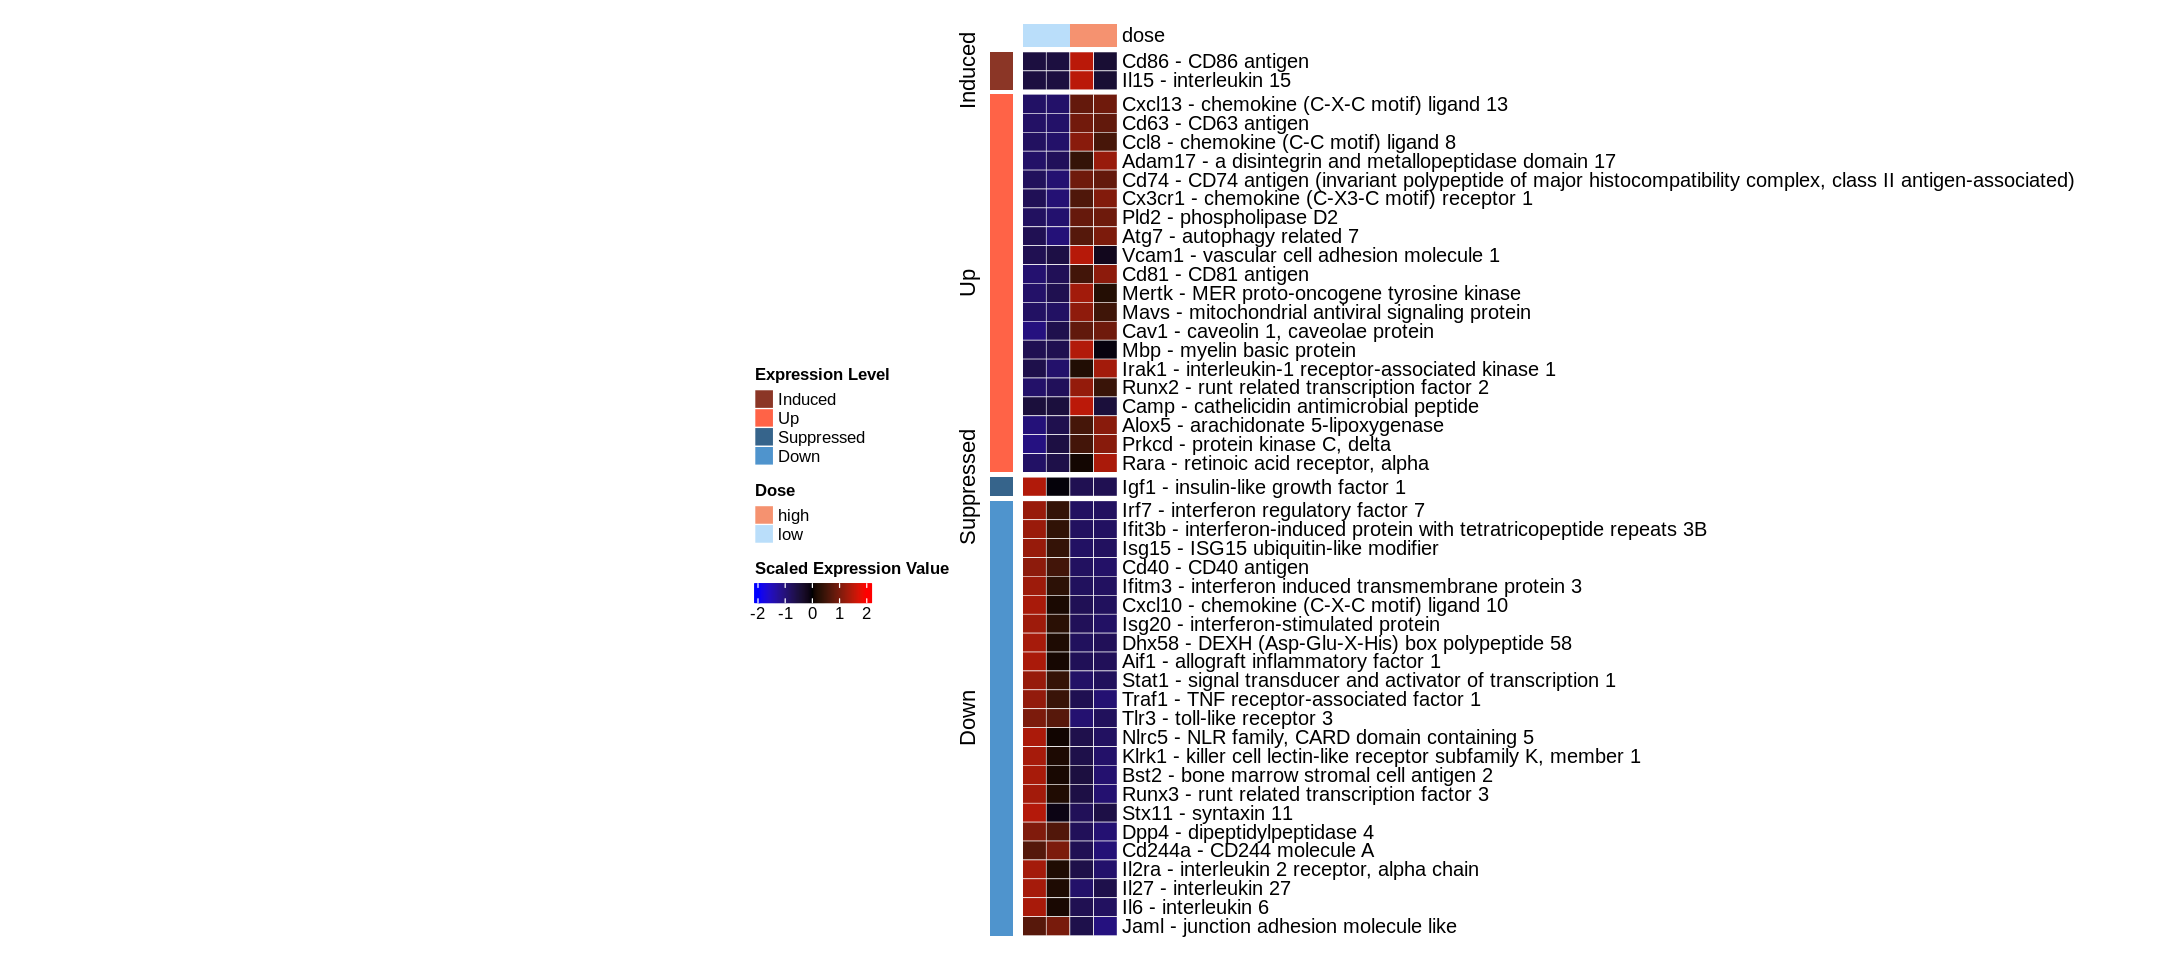

In [33]:
# Set plot size
options(repr.plot.width = 18, repr.plot.height = 8)
par(mar=c(0,0,4,0)) # bottom, left, top , right

# Plot two heatmaps  
h_list = h_pvalue + h_short_gene_names
draw(h_list, 
  heatmap_legend_side = "left", 
  annotation_legend_side = "left", 
  merge_legend = TRUE,
  #legend_grouping = "original",
  padding = unit(c(2, 3, 5, 2), "mm"))


### Plot heatmap with short gene names

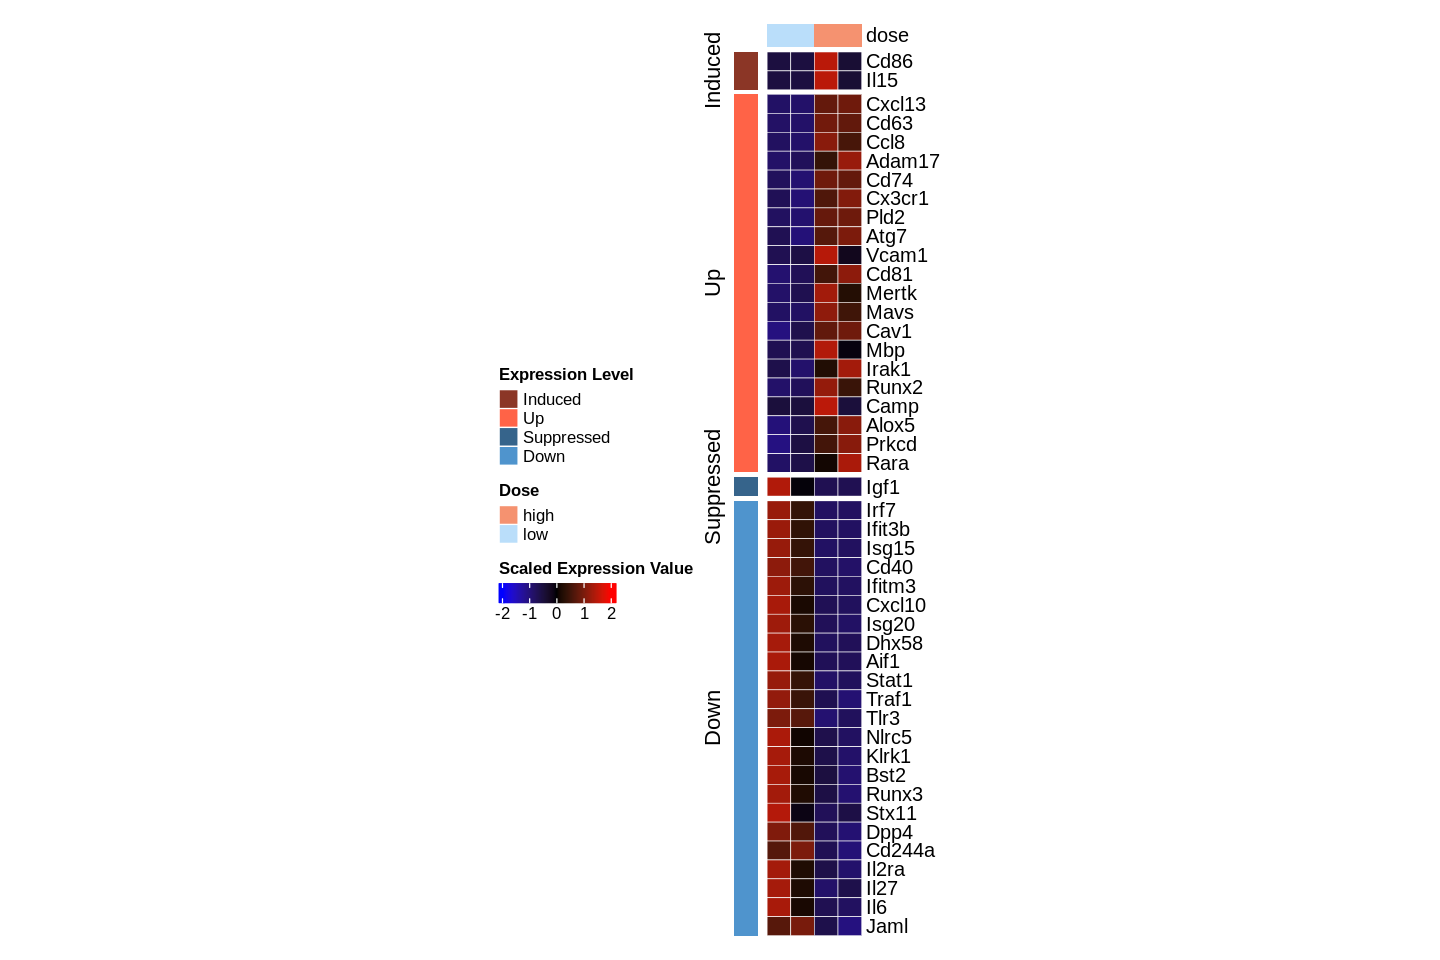

In [57]:
# Set plot size
options(repr.plot.width = 12, repr.plot.height = 8)
par(mar=c(0,0,4,0)) # bottom, left, top , right

h_list = h_pvalue + h_long_gene_names
draw(h_list, 
  heatmap_legend_side = "left", 
  annotation_legend_side = "left", 
  merge_legend = TRUE,
  #legend_grouping = "original",
  padding = unit(c(2, 3, 5, 2), "mm"))